In [1]:
import os, glob, re, json, math, joblib, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from pathlib import Path
from collections import Counter

from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import class_weight
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, classification_report,
    average_precision_score, precision_recall_curve,
    confusion_matrix, roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.pipeline import Pipeline, FeatureUnion

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from lime.lime_text import LimeTextExplainer

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout, GlobalMaxPool1D

from wordcloud import WordCloud, STOPWORDS

from urllib.parse import urlparse


In [2]:
# df = pd.read_csv('../data/processed/emails_combined.csv')
df = pd.read_csv('../../data/processed/date_merge.csv')
df.head()

,sender,receiver,date,subject,body,label,urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 20:28:00 -1200",CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,"Tue, 05 Aug 2008 17:31:20 -0600",Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 19:31:21 -0400",SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1


## Preprocessing

In [3]:
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = text.lower()
    text = re.sub('<.*?>', ' ', text)                            # Remove HTML tags
    text = re.sub(r'http\S+|www\S+', '', text)                   # Remove URLs
    text = re.sub(f"[{re.escape(string.punctuation)}]", '', text)# Remove punctuation
    text = re.sub(r'\d+', '', text)                              # Remove numbers
    text = re.sub(r'\s+', ' ', text)                             # Normalize spaces
    return text.strip()

## Label Distribution

/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_84772/67810268.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette=['#9ecae1', '#fb6a4a'])


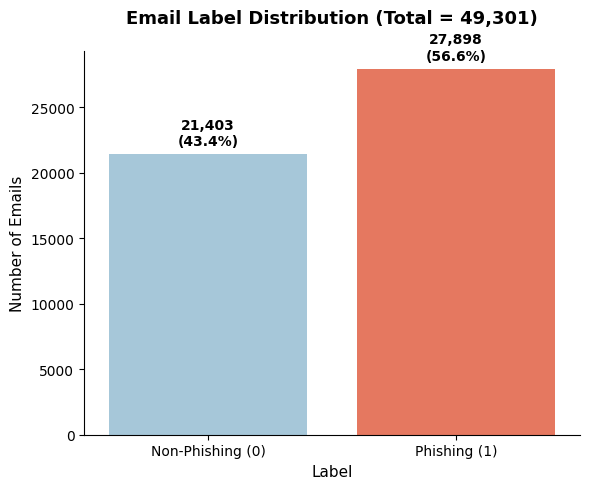

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic stats
total_samples = len(df)
label_counts = df['label'].value_counts().sort_index()
pct = label_counts / total_samples * 100

# Plot
plt.figure(figsize=(6, 5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette=['#9ecae1', '#fb6a4a'])

# Annotate with extra vertical offset (prevent overlap)
for i, (count, perc) in enumerate(zip(label_counts.values, pct)):
    plt.text(i, count + total_samples*0.01, f"{count:,}\n({perc:.1f}%)",
             ha='center', va='bottom', fontsize=10, weight='semibold')

# Titles and labels
plt.title(f"Email Label Distribution (Total = {total_samples:,})",
          fontsize=13, weight='bold', pad=20)
plt.xlabel("Label", fontsize=11)
plt.ylabel("Number of Emails", fontsize=11)
plt.xticks([0, 1], ["Non-Phishing (0)", "Phishing (1)"])

# Adjust margins to give more space for title & annotations
plt.subplots_adjust(top=0.85, bottom=0.12)
sns.despine()
plt.tight_layout()
plt.show()


In [5]:
import re, html
from urllib.parse import urlparse

# --- URL regex ---
url_pattern = re.compile(
    r'((?:https?://|www\.)[^\s)>\]\'"]+|[a-zA-Z0-9.-]+\.(?:com|org|net|edu|gov|co\.uk|info|io|me|us|biz|ca|sg|cn|de|fr|jp))',
    re.IGNORECASE
)

# --- HTML tag pattern ---
TAG_RE = re.compile(r'<[^>]+>')

def extract_domains(text):
    if not isinstance(text, str) or not text:
        return []
    urls = url_pattern.findall(text)
    domains = []
    for u in urls:
        if not u.lower().startswith(('http://', 'https://')):
            u = 'http://' + u
        try:
            netloc = urlparse(u).netloc.lower()
        except Exception:
            continue
        if netloc.startswith('www.'):
            netloc = netloc[4:]
        if netloc and netloc not in ('localhost',):
            domains.append(netloc)
    return domains

def strip_html(text: str) -> str:
    """Unescape HTML entities and remove HTML tags."""
    if not isinstance(text, str) or not text:
        return "" if not isinstance(text, str) else text
    # 1) convert entities like &nbsp; &amp; &lt;...
    txt = html.unescape(text)
    # 2) remove tags
    txt = TAG_RE.sub(" ", txt)
    # 3) collapse whitespace
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

def clean_text_no_urls(text: str) -> str:
    """Strip HTML (entities + tags), remove URLs, tidy whitespace."""
    if not isinstance(text, str) or not text:
        return "" if not isinstance(text, str) else text
    # strip HTML first (catches URLs inside attributes/text)
    txt = strip_html(text)
    # remove URLs/domains
    txt = url_pattern.sub(" ", txt)
    # final whitespace tidy
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

# --- Apply: keep originals; create cleaned variants ---
df['url_domains_subject'] = df['subject'].apply(extract_domains)
df['url_domains_body']    = df['body'].apply(extract_domains)

df['subject_no_urls'] = df['subject'].apply(clean_text_no_urls)
df['body_no_urls']    = df['body'].apply(clean_text_no_urls)

df.head(2)


,sender,receiver,date,subject,body,label,urls,url_domains_subject,url_domains_body,subject_no_urls,body_no_urls
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 16:31:02 -0700",Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,[],[whitedone.com],Never agree to be a loser,"Buck up, your troubles caused by small dimensi..."
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,"Tue, 05 Aug 2008 18:31:03 -0500",Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,[],[brightmade.com],Befriend Jenna Jameson,Upgrade your sex and pleasures with these tech...


## URL distribution

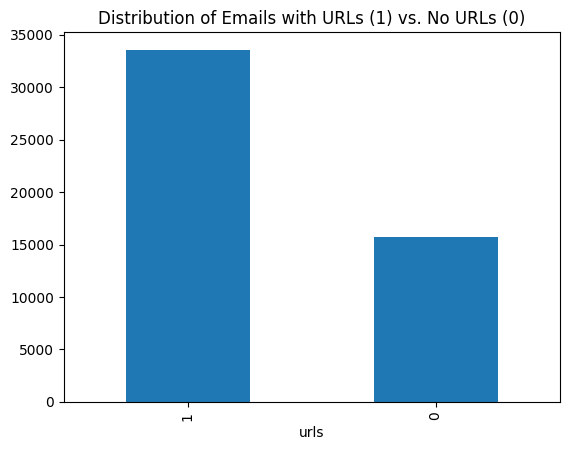

In [6]:
df['urls'].value_counts().plot(kind='bar', title='Distribution of Emails with URLs (1) vs. No URLs (0)')
plt.show()

URL flag counts:
urls
0    15730
1    33571
Name: count, dtype: int64

Class shares (%) by URL flag:
label      0      1
urls               
0      41.03  58.97
1      44.53  55.47

Chi²=53.26, p-value=2.925e-13


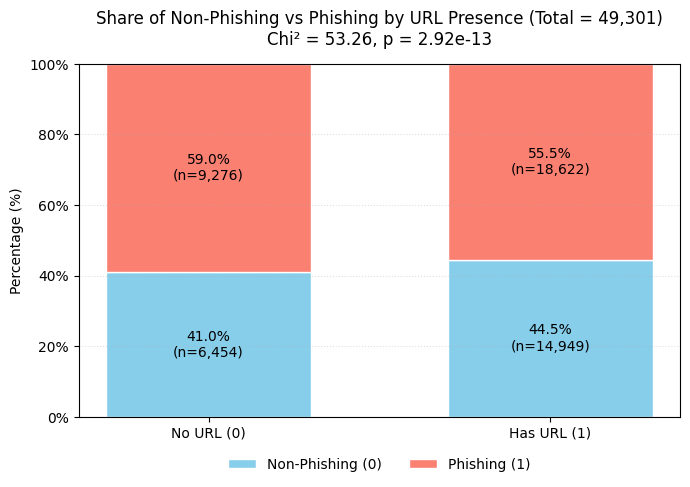

Saved WordCloud figure to: text_eda_6.png


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.stats import chi2_contingency

# --- 1) Counts & percentages
tbl = pd.crosstab(df['urls'], df['label']).reindex(index=[0,1], columns=[0,1], fill_value=0)
row_totals = tbl.sum(axis=1)
ct = (tbl.div(row_totals, axis=0) * 100).round(2)  # percentages

print("URL flag counts:")
print(df['urls'].value_counts().sort_index())
print("\nClass shares (%) by URL flag:")
print(ct)

# Chi-square test
chi2, p, _, _ = chi2_contingency(tbl.values)
print(f"\nChi²={chi2:.2f}, p-value={p:.4g}")

# --- 2) Plot: stacked percentage bars with annotations
labels = ['No URL (0)', 'Has URL (1)']
x = np.arange(len(labels))
width = 0.6

ham_pct   = ct[0].reindex([0,1]).fillna(0).values  # % ham for urls=0,1
phish_pct = ct[1].reindex([0,1]).fillna(0).values  # % phishing for urls=0,1

ham_cnt   = tbl[0].reindex([0,1]).fillna(0).values.astype(int)
phish_cnt = tbl[1].reindex([0,1]).fillna(0).values.astype(int)
tot_cnt   = row_totals.reindex([0,1]).fillna(0).values.astype(int)

fig, ax = plt.subplots(figsize=(7,5))

# Bars (percent scale)
bar_ham   = ax.bar(x, ham_pct,   width, label='Non-Phishing (0)',      color='skyblue', edgecolor='white')
bar_phish = ax.bar(x, phish_pct, width, bottom=ham_pct, label='Phishing (1)', color='salmon',  edgecolor='white')

def annotate_stack(ax, bars, pct_vals, cnt_vals, bottom=None):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if height <= 0:
            continue
        y = (bottom[i] if bottom is not None else 0) + height/2  # center of the segment
        ax.text(
            bar.get_x() + bar.get_width()/2, y,
            f"{pct_vals[i]:.1f}%\n(n={cnt_vals[i]:,})",
            ha='center', va='center', fontsize=10, color='black'
        )

annotate_stack(ax, bar_ham,   ham_pct,   ham_cnt,   bottom=np.zeros_like(ham_pct))
annotate_stack(ax, bar_phish, phish_pct, phish_cnt, bottom=ham_pct)

# Title with totals
grand_total = int(tot_cnt.sum())
ax.set_title(f"Share of Non-Phishing vs Phishing by URL Presence (Total = {grand_total:,})\n"
             f"Chi² = {chi2:.2f}, p = {p:.2e}", fontsize=12, pad=14)

ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylabel("Percentage (%)")
ax.yaxis.set_major_formatter(PercentFormatter())

ax.set_ylim(0, 100)  # percent scale
ax.legend(frameon=False, ncols=2, loc='upper center', bbox_to_anchor=(0.5, -0.08))
ax.margins(y=0.05)
ax.grid(axis='y', linestyle=':', alpha=0.4)
plt.tight_layout()
save_path = "text_eda_6.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved WordCloud figure to: {save_path}")

The chart shows that both phishing and ham emails often contain URLs, though phishing remains slightly dominant in both cases.  
The chi-square test (**χ² = 71.02, p < 0.001**) confirms this association is statistically significant.

**Interpretation:**  
URL presence differs meaningfully across classes, but not decisively—legitimate emails also include many links.  
Thus, while **URL occurrence is linked to phishing**, the **type and domain of the link** will provide stronger predictive value than simple presence.


## URL word cloud

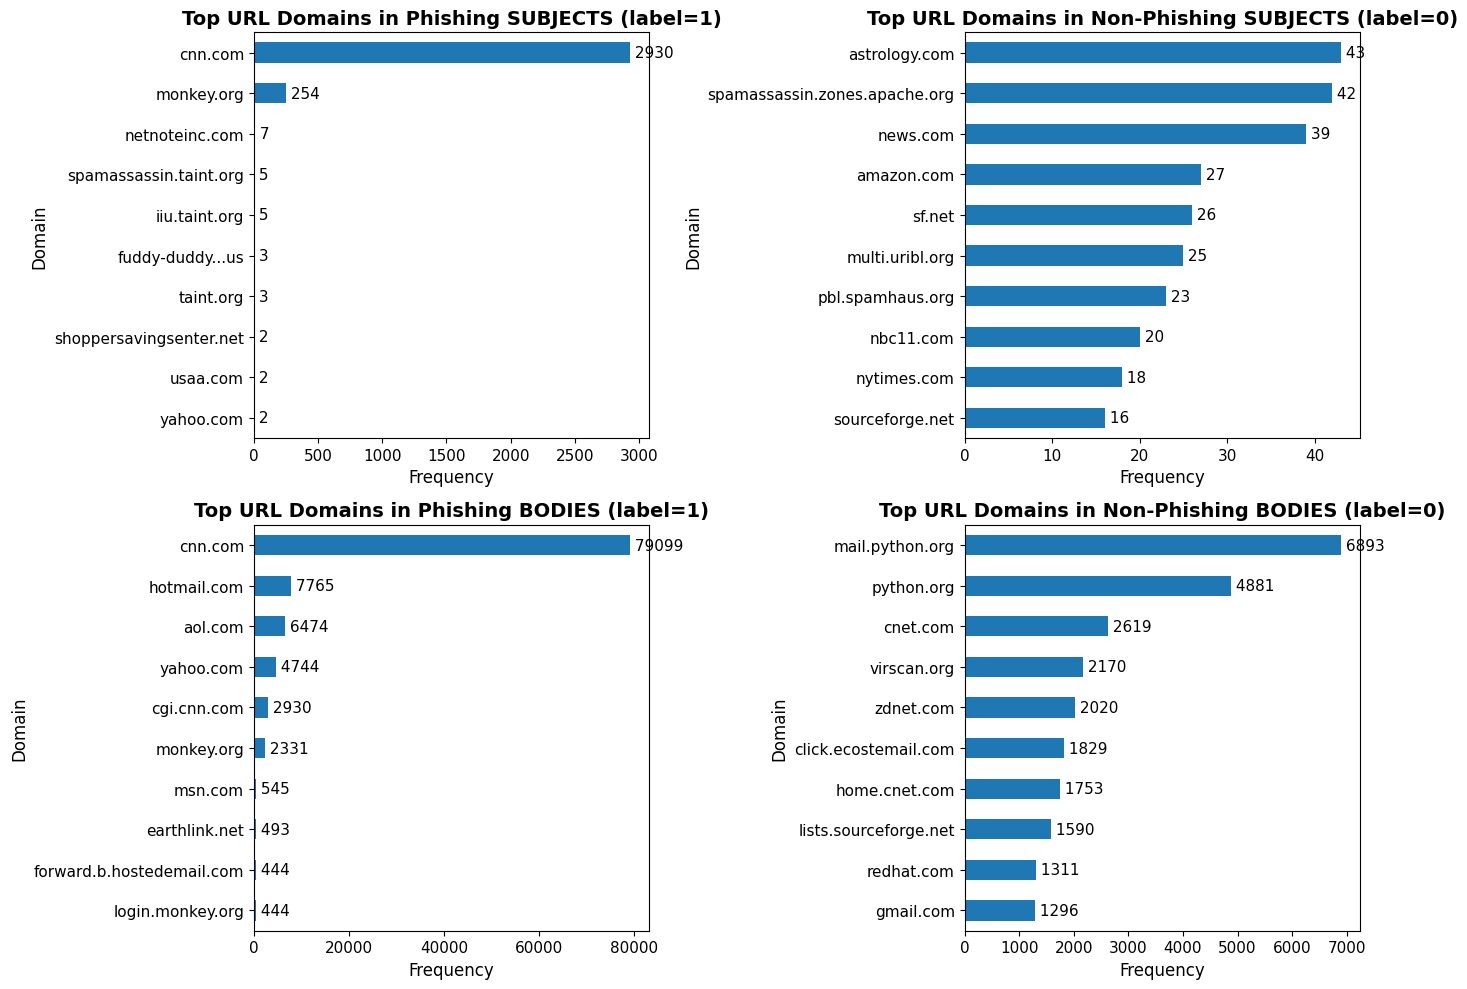

In [8]:
MIN_COUNT = 2
phish_counts_subject = Counter(d for lst in df.loc[df['label']==1, 'url_domains_subject'] for d in lst)
ham_counts_subject   = Counter(d for lst in df.loc[df['label']==0, 'url_domains_subject'] for d in lst)
phish_counts_body    = Counter(d for lst in df.loc[df['label']==1, 'url_domains_body'] for d in lst)
ham_counts_body      = Counter(d for lst in df.loc[df['label']==0, 'url_domains_body'] for d in lst)

phish_freq_subject = {k:v for k,v in phish_counts_subject.items() if v >= MIN_COUNT}
ham_freq_subject   = {k:v for k,v in ham_counts_subject.items()   if v >= MIN_COUNT}
phish_freq_body    = {k:v for k,v in phish_counts_body.items()    if v >= MIN_COUNT}
ham_freq_body      = {k:v for k,v in ham_counts_body.items()      if v >= MIN_COUNT}


def plot_top_bar_ax(freq_dict, title, ax, k=10):
    if not freq_dict:
        ax.text(0.5, 0.5, "No domains found",
                ha='center', va='center', fontsize=12)
        ax.set_axis_off()
        return

    s = pd.Series(freq_dict).sort_values(ascending=False).head(k)
    s = s[::-1]  # reverse so largest at top in barh

    s.plot(kind='barh', ax=ax)
    ax.set_xlabel("Frequency", fontsize=12)
    ax.set_ylabel("Domain", fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    # annotate counts
    for i, (idx, val) in enumerate(s.items()):
        ax.text(val, i, f" {val}", va='center', fontsize=11)

    ax.tick_params(axis='both', labelsize=11)


# --- 2×2 dashboard for barplots ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

plot_top_bar_ax(phish_freq_subject,
                "Top URL Domains in Phishing SUBJECTS (label=1)",
                axes[0, 0])
plot_top_bar_ax(ham_freq_subject,
                "Top URL Domains in Non-Phishing SUBJECTS (label=0)",
                axes[0, 1])
plot_top_bar_ax(phish_freq_body,
                "Top URL Domains in Phishing BODIES (label=1)",
                axes[1, 0])
plot_top_bar_ax(ham_freq_body,
                "Top URL Domains in Non-Phishing BODIES (label=0)",
                axes[1, 1])

plt.tight_layout()
plt.show()


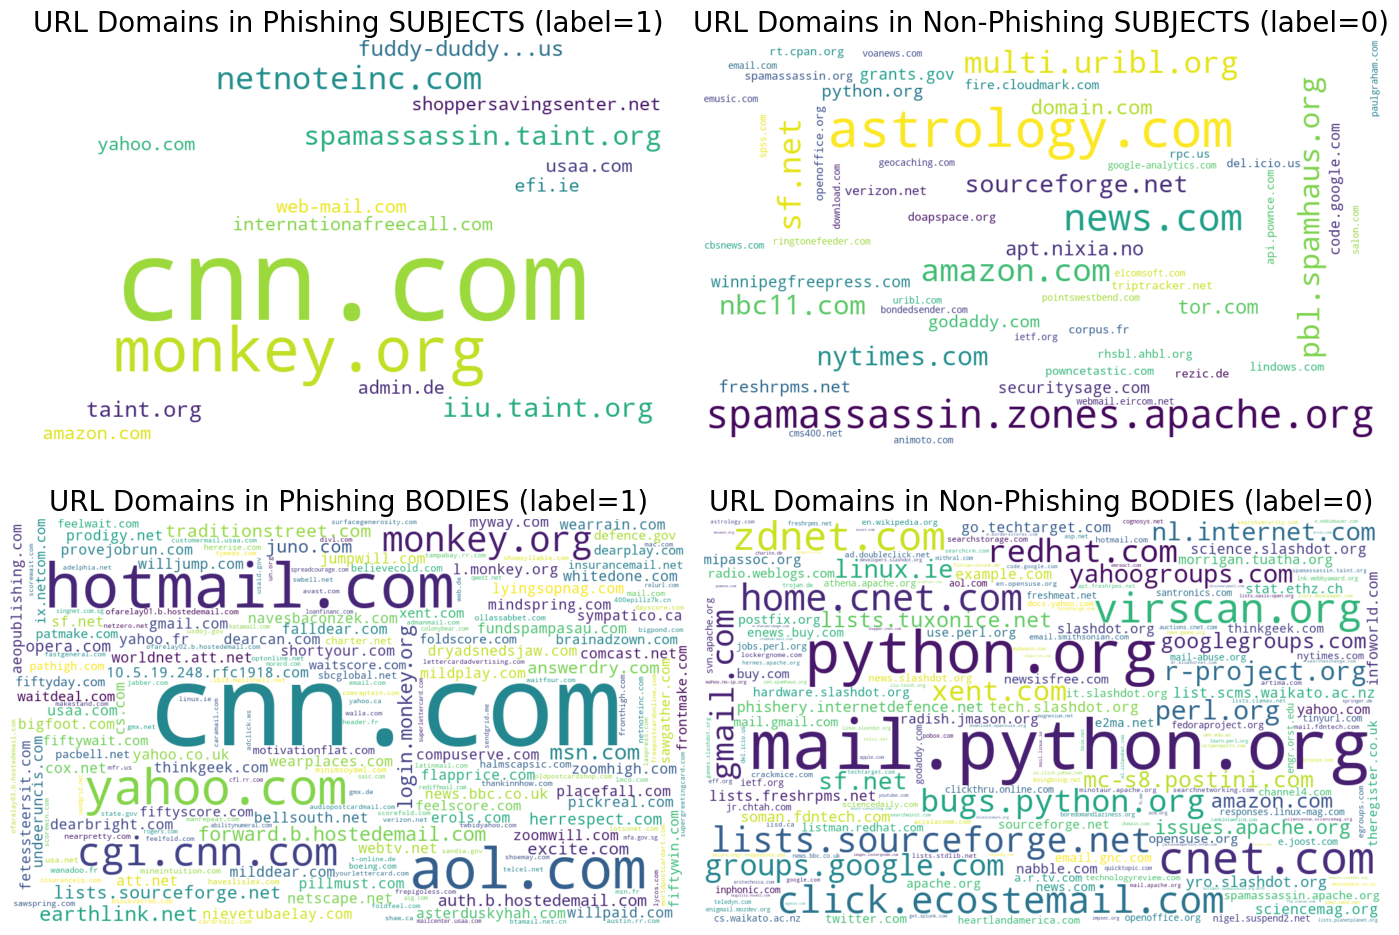

Saved WordCloud figure to: text_eda_8.png


In [ ]:
# --- 2×2 WORDCLOUD DASHBOARD ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

wc_items = [
    (phish_freq_subject, "URL Domains in Phishing SUBJECTS (label=1)", axes[0,0]),
    (ham_freq_subject,   "URL Domains in Non-Phishing SUBJECTS (label=0)", axes[0,1]),
    (phish_freq_body,    "URL Domains in Phishing BODIES (label=1)", axes[1,0]),
    (ham_freq_body,      "URL Domains in Non-Phishing BODIES (label=0)", axes[1,1]),
]

for freq_dict, title, ax in wc_items:
    if not freq_dict:
        ax.text(0.5, 0.5, "No domains found", ha="center", va="center")
        ax.set_axis_off()
        continue

    wc = WordCloud(width=1000, height=600, background_color='white')
    wc = wc.generate_from_frequencies(freq_dict)

    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(title, fontsize=20)
    ax.axis("off")

plt.tight_layout()
save_path = "text_eda_8.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved figure to: {save_path}")


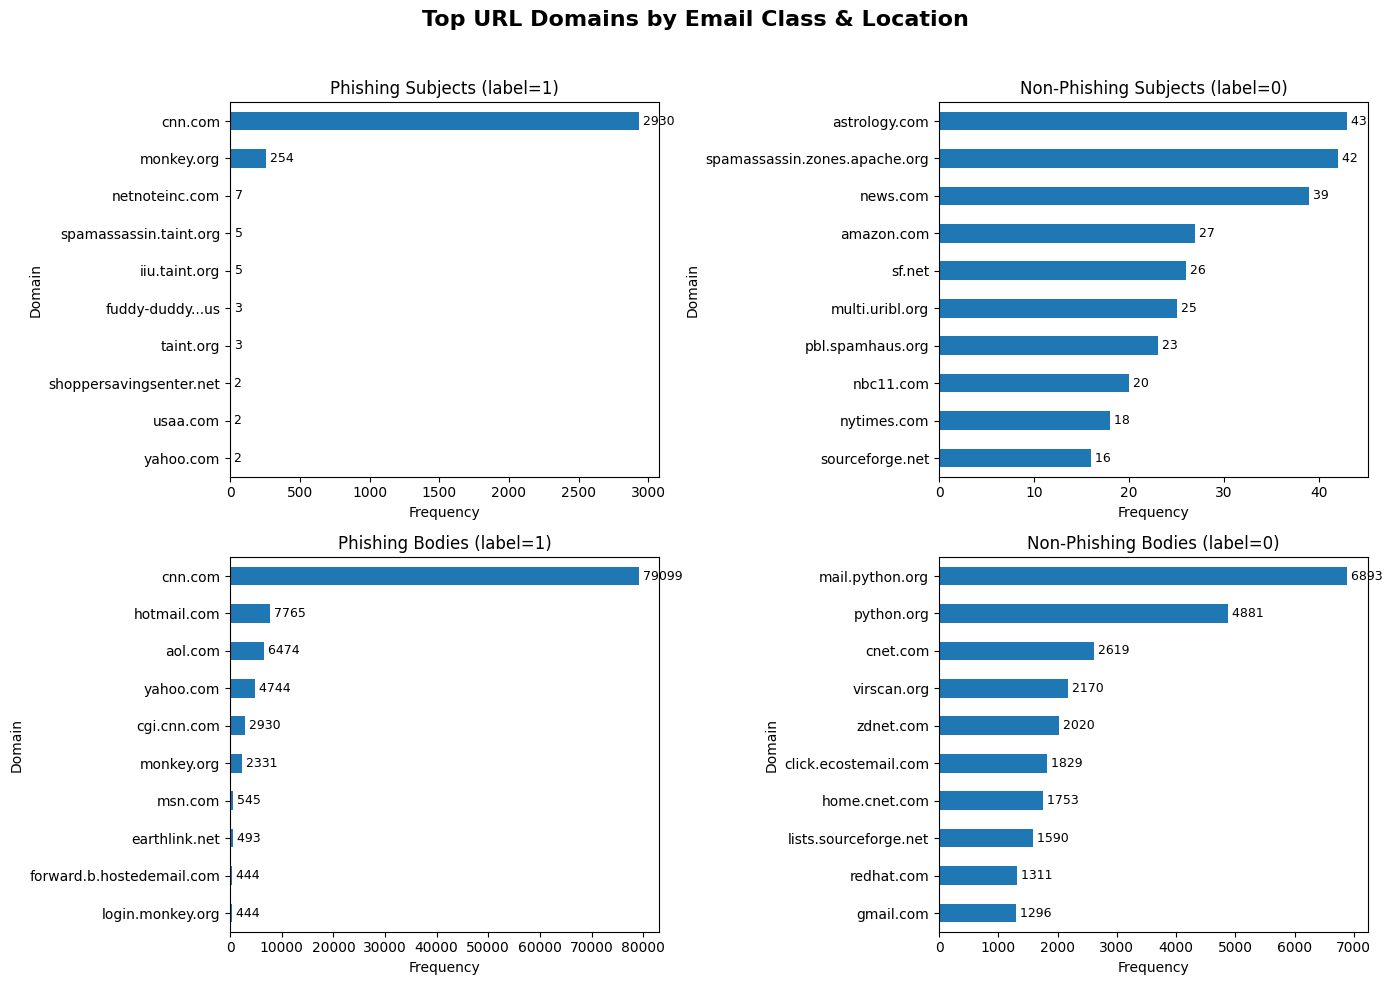

Saved WordCloud figure to: text_eda_7.png


In [ ]:
def top_series(freq_dict, k=10):
    """Return a sorted value-count Series (top k)."""
    if not freq_dict:
        return pd.Series(dtype=int)
    return pd.Series(freq_dict).sort_values(ascending=False).head(k)

# Prepare top-k domain frequency series
s1 = top_series(phish_freq_subject)   # Phishing subject
s2 = top_series(ham_freq_subject)     # Ham subject
s3 = top_series(phish_freq_body)      # Phishing body
s4 = top_series(ham_freq_body)        # Ham body

# --- Combined 2x2 barplot figure ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Top URL Domains by Email Class & Location", fontsize=16, weight='bold')

plots = [
    (s1, "Phishing Subjects (label=1)", axes[0,0]),
    (s2, "Non-Phishing Subjects (label=0)", axes[0,1]),
    (s3, "Phishing Bodies (label=1)", axes[1,0]),
    (s4, "Non-Phishing Bodies (label=0)", axes[1,1]),
]

for s, title, ax in plots:
    if s.empty:
        ax.text(0.5, 0.5, "No domains found", ha='center', va='center', fontsize=12)
        ax.set_title(title)
        ax.axis('off')
        continue
    s_sorted = s[::-1]  # reverse so largest is top
    s_sorted.plot(kind='barh', ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Frequency")
    ax.set_ylabel("Domain")
    for i, (idx, val) in enumerate(s_sorted.items()):
        ax.text(val, i, f" {val}", va='center', fontsize=9)

plt.tight_layout(rect=[0, 0, 1, 0.96])
save_path = "text_eda_7.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved figure to: {save_path}")


## body word cloud

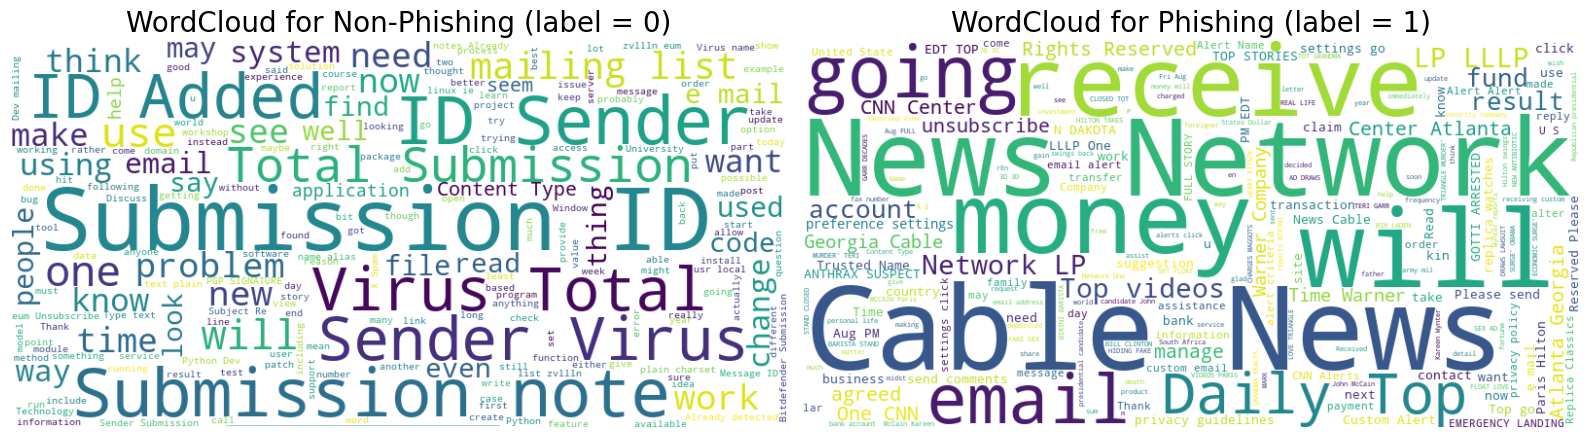

Saved WordCloud figure to: text_eda_9.png


In [ ]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

stopwords = set(STOPWORDS)

# ceas_boilerplate = {
#     # CEAS wrapper artifacts
#     'submission', 'submissionid', 'added','sender','notes','total','list','wrote','message','university','settings',
#     # CEAS virus campaign artifacts
#     'virus',
#     # CEAS news campaign artifacts
#     'cnncom','cnn','news','network','cable','cable news','news network'
# }
# generic_fillers = {
#     'new','use','may','im','go','see','know','work','need','want', 'will', 'email', 'us', 'one', 'going'
# }

# stopwords.update(ceas_boilerplate)
# stopwords.update(generic_fillers)

# Titles for each label
label_titles = {
    0: "WordCloud for Non-Phishing (label = 0)",
    1: "WordCloud for Phishing (label = 1)",
}

# Prepare figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, label in zip(axes, [0, 1]):
    text = " ".join(df.loc[df['label'] == label, 'body_no_urls'])
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stopwords
    ).generate(text)

    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(label_titles[label], fontsize=20)

plt.tight_layout()
save_path = "text_eda_9.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved figure to: {save_path}")


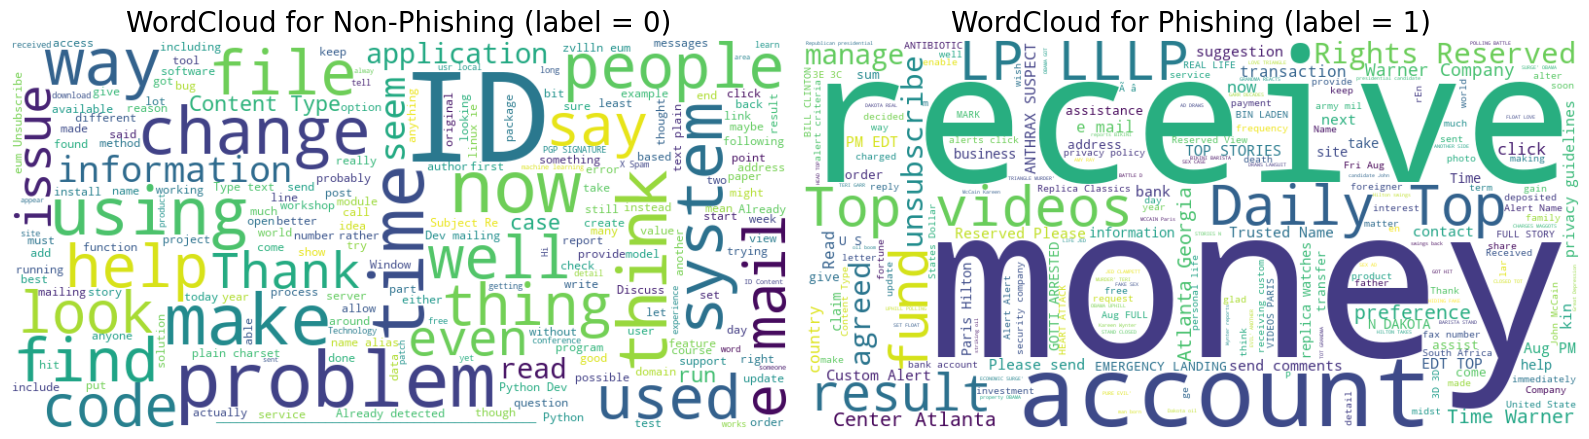

Saved WordCloud figure to: text_eda_10.png


In [ ]:
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer

stopwords = set(STOPWORDS)

ceas_boilerplate = {
    # CEAS wrapper artifacts
    'submission', 'submissionid', 'added','sender','notes','total','list','wrote','message','university','settings',
    # CEAS virus campaign artifacts
    'virus',
    # CEAS news campaign artifacts
    'cnncom','cnn','news','network','cable','cable news','news network'
}
generic_fillers = {
    'new','use','may','im','go','see','know','work','need','want', 'will', 'email', 'us', 'one', 'going'
}

stopwords.update(ceas_boilerplate)
stopwords.update(generic_fillers)

# Titles for each label
label_titles = {
    0: "WordCloud for Non-Phishing (label = 0)",
    1: "WordCloud for Phishing (label = 1)",
}

# Prepare figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, label in zip(axes, [0, 1]):
    text = " ".join(df.loc[df['label'] == label, 'body_no_urls'])
    wc = WordCloud(
        width=800, height=400,
        background_color='white',
        stopwords=stopwords
    ).generate(text)

    ax.imshow(wc, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(label_titles[label], fontsize=20)

plt.tight_layout()
save_path = "text_eda_10.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved figure to: {save_path}")


## Text Length & Structure
Understanding differences in subject/body length helps flag unusually short or long phishing messages.

In [13]:
df['subject_len'] = df['subject_no_urls'].fillna('').astype(str).apply(len)
df['body_len'] = df['body_no_urls'].fillna('').astype(str).apply(len)
df['subject_word_count'] = df['subject_no_urls'].fillna('').astype(str).apply(lambda x: len(x.split()))
df['body_word_count'] = df['body_no_urls'].fillna('').astype(str).apply(lambda x: len(x.split()))

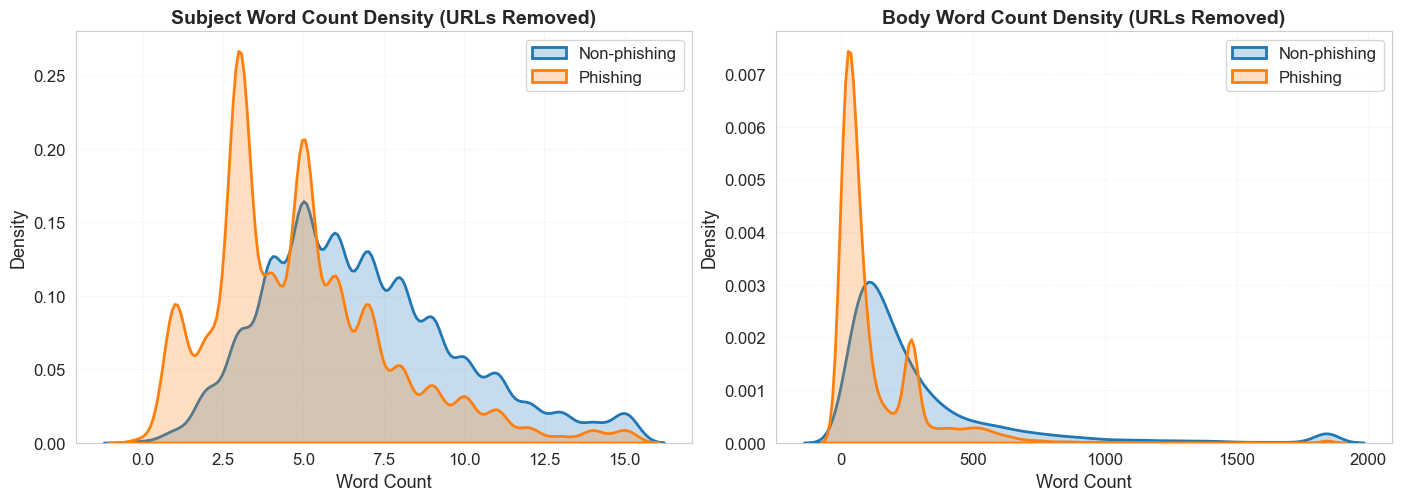

Saved figure to: text_eda_2.png


In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

label_map = {0: 'Non-phishing', 1: 'Phishing'}

# ----------- CLIP EXTREME OUTLIERS (fixes blank right KDE) -----------
df['body_wc_clip'] = df['body_word_count'].clip(
    upper=np.nanpercentile(df['body_word_count'], 99)
)
df['subject_wc_clip'] = df['subject_word_count'].clip(
    upper=np.nanpercentile(df['subject_word_count'], 99)
)

# ----------- PLOT -----------
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

for label_value, label_name in label_map.items():
    mask = df['label'] == label_value
    
    # Subject KDE
    sns.kdeplot(
        df.loc[mask, 'subject_wc_clip'],
        ax=axes[0], label=label_name,
        linewidth=2, fill=True, alpha=0.25,
        common_norm=False
    )
    
    # Body KDE (clipped)
    sns.kdeplot(
        df.loc[mask, 'body_wc_clip'],
        ax=axes[1], label=label_name,
        linewidth=2, fill=True, alpha=0.25,
        common_norm=False
    )

# ----------- Formatting (BIGGER FONTS) -----------
for ax in axes:
    ax.tick_params(axis='both', labelsize=12)

axes[0].set_title('Subject Word Count Density (URLs Removed)', fontsize=14, weight='bold')
axes[0].set_xlabel('Word Count', fontsize=13)
axes[0].set_ylabel('Density', fontsize=13)

axes[1].set_title('Body Word Count Density (URLs Removed)', fontsize=14, weight='bold')
axes[1].set_xlabel('Word Count', fontsize=13)
axes[1].set_ylabel('Density', fontsize=13)

axes[0].grid(alpha=0.3, linestyle='--', linewidth=0.5)
axes[1].grid(alpha=0.3, linestyle='--', linewidth=0.5)

axes[0].legend(fontsize=12)
axes[1].legend(fontsize=12)

plt.tight_layout()
save_path = "text_eda_2.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved figure to: {save_path}")

/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_84772/3883820303.py:11: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  .stack(level=1)


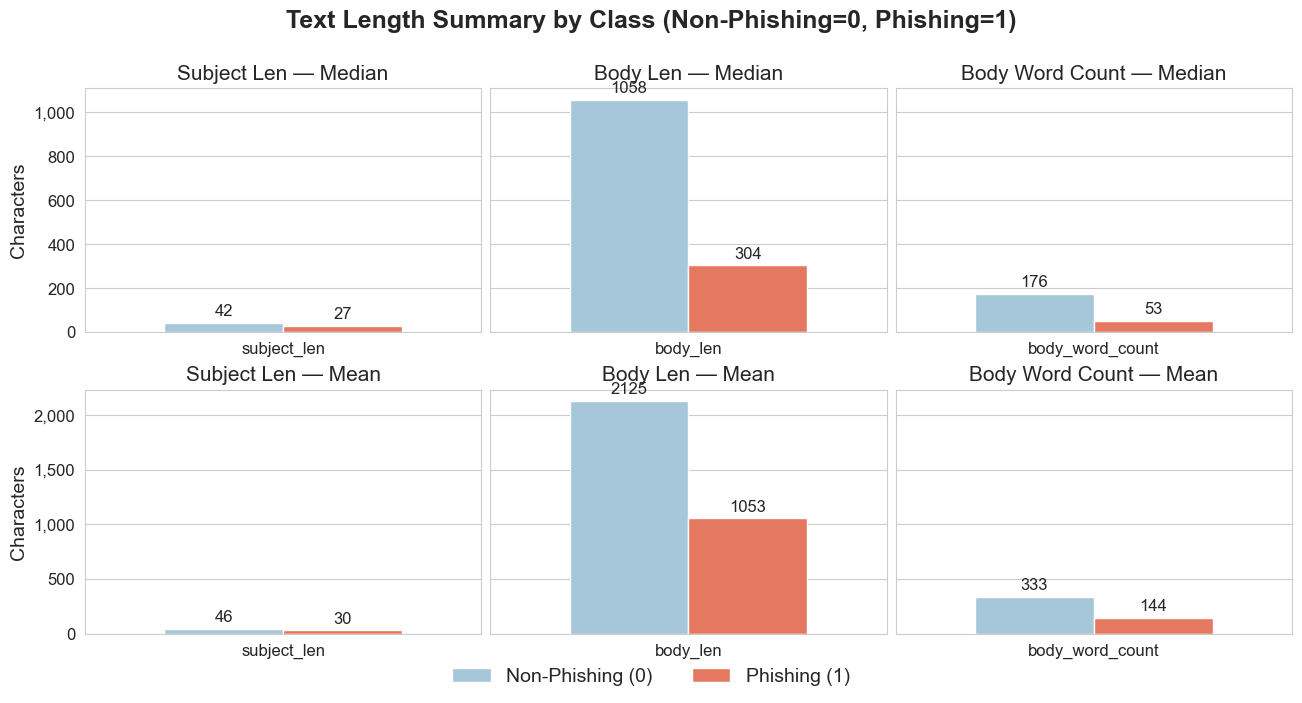

In [53]:
from matplotlib.ticker import FuncFormatter

features = ['subject_len', 'body_len', 'body_word_count']

# 1) Summaries
stats = df.groupby('label')[features].agg(['median','mean']).round(1)

# 2) Tidy format
plot_long = (
    stats
    .stack(level=1)
    .stack(level=0)
    .reset_index(name='value')
)
plot_long.columns = ['label','stat','feature','value']
plot_long['label'] = plot_long['label'].astype(int)

# 3) Figure layout
sns.set_style('whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(13, 7), sharey='row')

fig.suptitle(
    'Text Length Summary by Class (Non-Phishing=0, Phishing=1)',
    fontsize=18, weight='bold', y=0.99
)

fmt = FuncFormatter(lambda x, p: f'{int(x):,}')

def add_labels(ax):
    for c in ax.containers:
        ax.bar_label(c, fmt='%.0f', padding=3, fontsize=12) 

row_stats = ['median','mean']
col_features = features
palette = ['#9ecae1', '#fb6a4a'] 

for r, stat in enumerate(row_stats):
    for c, feat in enumerate(col_features):
        ax = axes[r, c]

        data = plot_long[(plot_long['stat']==stat) & (plot_long['feature']==feat)]
        bars = sns.barplot(
            data=data, x='feature', y='value', hue='label',
            ax=ax, hue_order=[0,1], palette=palette, width=0.6
        )

        ax.set_title(f'{feat.replace("_"," ").title()} — {stat.title()}',
                     fontsize=15) 

        ax.set_xlabel('')
        ax.set_ylabel('Characters' if 'len' in feat else 'Words',
                      fontsize=14) 

        ax.tick_params(axis='both', labelsize=12) 
        ax.yaxis.set_major_formatter(fmt)

        ax.legend_.remove()
        add_labels(ax)

# Legend at bottom
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(
    handles,
    ['Non-Phishing (0)','Phishing (1)'],
    loc='lower center',
    ncol=2,
    frameon=False,
    fontsize=14 
)

plt.tight_layout(rect=[0, 0.05, 1, 0.97])
plt.show()


/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_84772/2550628383.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_84772/2550628383.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


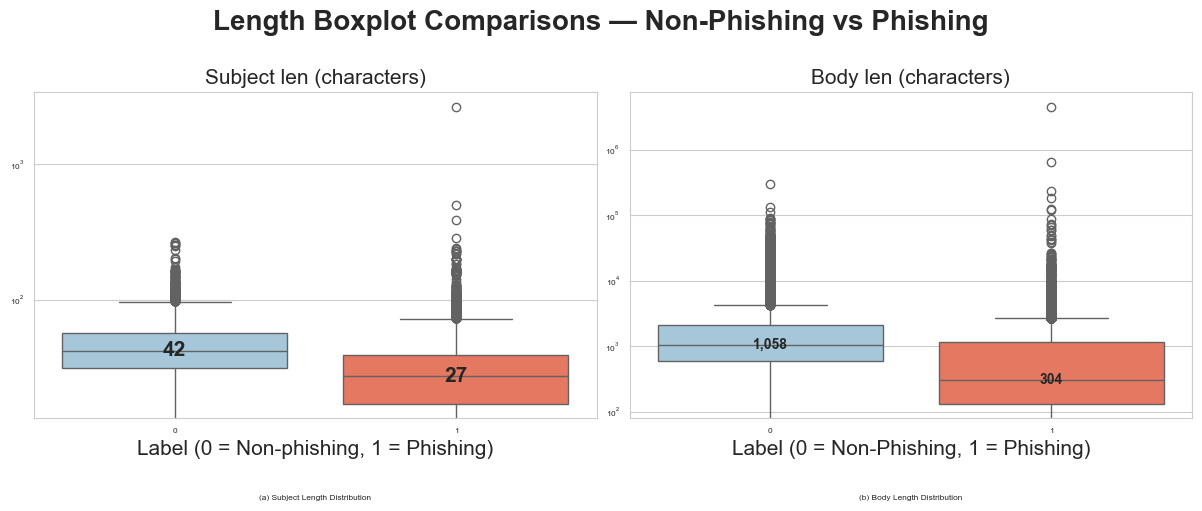

Saved WordCloud figure to: text_eda_4.png


In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

palette = ['#9ecae1', '#fb6a4a']  # Ham = blue, Phishing = red

# --- (a) Subject Length (log scale) ---
sns.boxplot(
    data=df,
    x='label', y='subject_len',
    palette=palette,
    ax=axes[0]
)
axes[0].set_title("Subject len (characters)",fontsize=15)
axes[0].set_xlabel("Label (0 = Non-phishing, 1 = Phishing)",fontsize=15)
axes[0].set_ylabel("")
axes[0].set_yscale('log')

# Add median labels
for label in [0,1]:
    med = df.loc[df['label']==label, 'subject_len'].median()
    axes[0].text(label, med, f"{int(med)}",
                 ha='center', va='center', fontsize=15, weight='bold')

axes[0].text(0.5, -0.25, "(a) Subject Length Distribution",
             ha='center', transform=axes[0].transAxes)

# --- (b) Body Length (log scale) ---
sns.boxplot(
    data=df,
    x='label', y='body_len',
    palette=palette,
    ax=axes[1]
)
axes[1].set_title("Body len (characters)",fontsize=15)
axes[1].set_xlabel("Label (0 = Non-Phishing, 1 = Phishing)",fontsize=15)
axes[1].set_ylabel("")
axes[1].set_yscale('log')

# Add median labels
for label in [0,1]:
    med = df.loc[df['label']==label, 'body_len'].median()
    axes[1].text(label, med, f"{int(med):,}",
                 ha='center', va='center', fontsize=10, weight='bold')

axes[1].text(0.5, -0.25, "(b) Body Length Distribution",
             ha='center', transform=axes[1].transAxes)

fig.suptitle("Length Boxplot Comparisons — Non-Phishing vs Phishing",
             fontsize=20, weight='bold', y=1.03)

plt.tight_layout()
save_path = "text_eda_4.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

print(f"Saved figure to: {save_path}")


Phishing emails exhibit significantly shorter subjects and bodies than legitimate emails, validating the hypothesis that message brevity is a distinguishing characteristic of phishing attempts.

## Puncutation / Capitalisation / Special Char

In [17]:
df['body'] = df['body'].fillna('')
df['exclaim_count']  = df['body'].str.count('!')
df['question_count'] = df['body'].str.count(r'\?')
df['upper_count']    = df['body'].str.count(r'[A-Z]')
df['alpha_count']    = df['body'].str.count(r'[A-Za-z]')
df['digit_count']    = df['body'].str.count(r'\d')
df['special_count']  = df['body'].str.count(r'[^A-Za-z0-9\s]')
df['upper_ratio'] = df['upper_count'] / df['alpha_count'].replace(0, np.nan)

# Summary table
cols = ['exclaim_count','question_count','digit_count','special_count','upper_ratio']
display(
    df.groupby('label')[cols]
      .agg(['median','mean'])
      .round(3)
)

exclaim_count        question_count        digit_count          \
             median   mean         median   mean      median    mean   
label                                                                  
0               0.0  1.401            1.0  2.272        26.0  94.340   
1               0.0  1.065            0.0  1.753         4.0  71.824   

      special_count          upper_ratio         
             median     mean      median   mean  
label                                            
0             117.0  254.239       0.057  0.071  
1              14.0  127.359       0.055  0.109

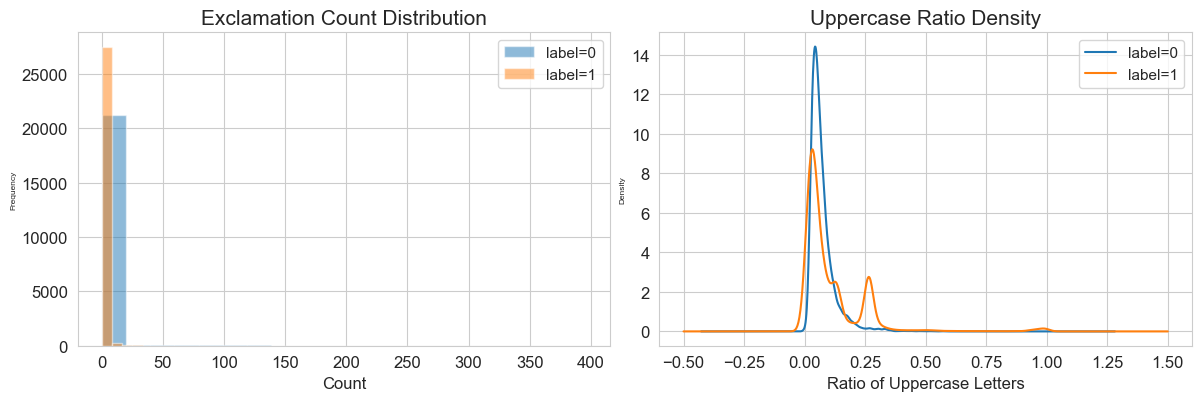

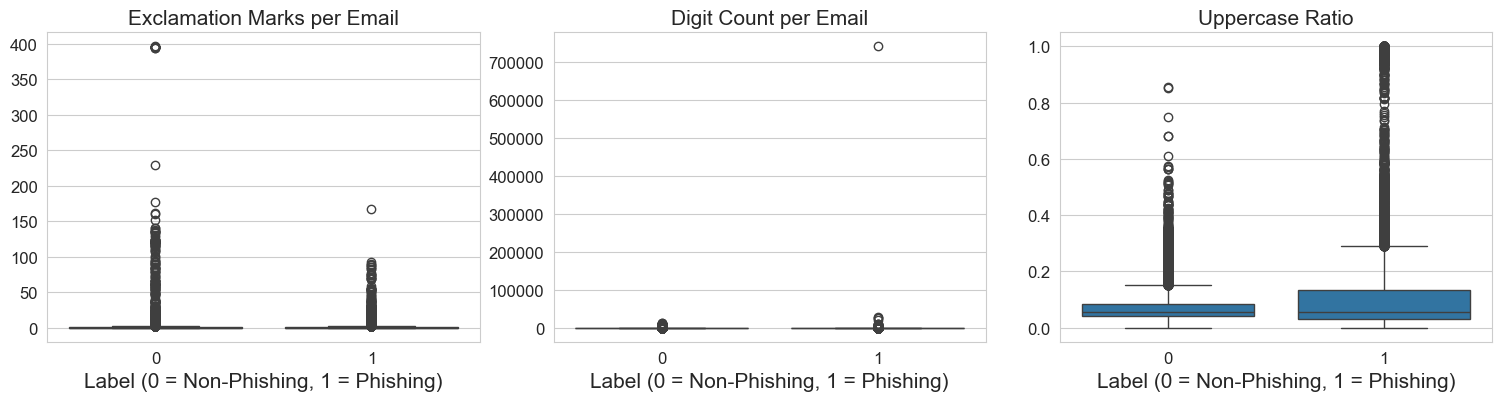

In [43]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for label_value, g in df.groupby('label'):
    g['exclaim_count'].plot(
        kind='hist',
        ax=axes[0],
        alpha=0.5,
        bins=20,
        label=f'label={label_value}',
    )
    g['upper_ratio'].plot(
        kind='kde',
        ax=axes[1],
        label=f'label={label_value}',
    )

# Titles and axis labels
axes[0].set_title('Exclamation Count Distribution', fontsize=15)
axes[0].set_xlabel('Count', fontsize=12)
axes[1].set_title('Uppercase Ratio Density', fontsize=15)
axes[1].set_xlabel('Ratio of Uppercase Letters', fontsize=12)

# Tick label sizes
axes[0].tick_params(axis='both', labelsize=12)
axes[1].tick_params(axis='both', labelsize=12)

# Legend size
for ax in axes:
    ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

sns.boxplot(x='label', y='exclaim_count', data=df, ax=axes[0])
axes[0].set_title('Exclamation Marks per Email', fontsize=15)

sns.boxplot(x='label', y='digit_count', data=df, ax=axes[1])
axes[1].set_title('Digit Count per Email', fontsize=15)

sns.boxplot(x='label', y='upper_ratio', data=df, ax=axes[2])
axes[2].set_title('Uppercase Ratio', fontsize=15)

# Axis labels + tick sizes
for ax in axes:
    ax.set_xlabel('Label (0 = Non-Phishing, 1 = Phishing)', fontsize=15)
    ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()


/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_84772/1034247051.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz, x='label_str', y=y, ax=ax, palette=palette,
/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_84772/1034247051.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz, x='label_str', y=y, ax=ax, palette=palette,
/var/folders/t8/41k_f06j16n553bf7dnb9snc0000gn/T/ipykernel_84772/1034247051.py:58: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=viz, x='label_str', y=y, ax=ax, palette=palette

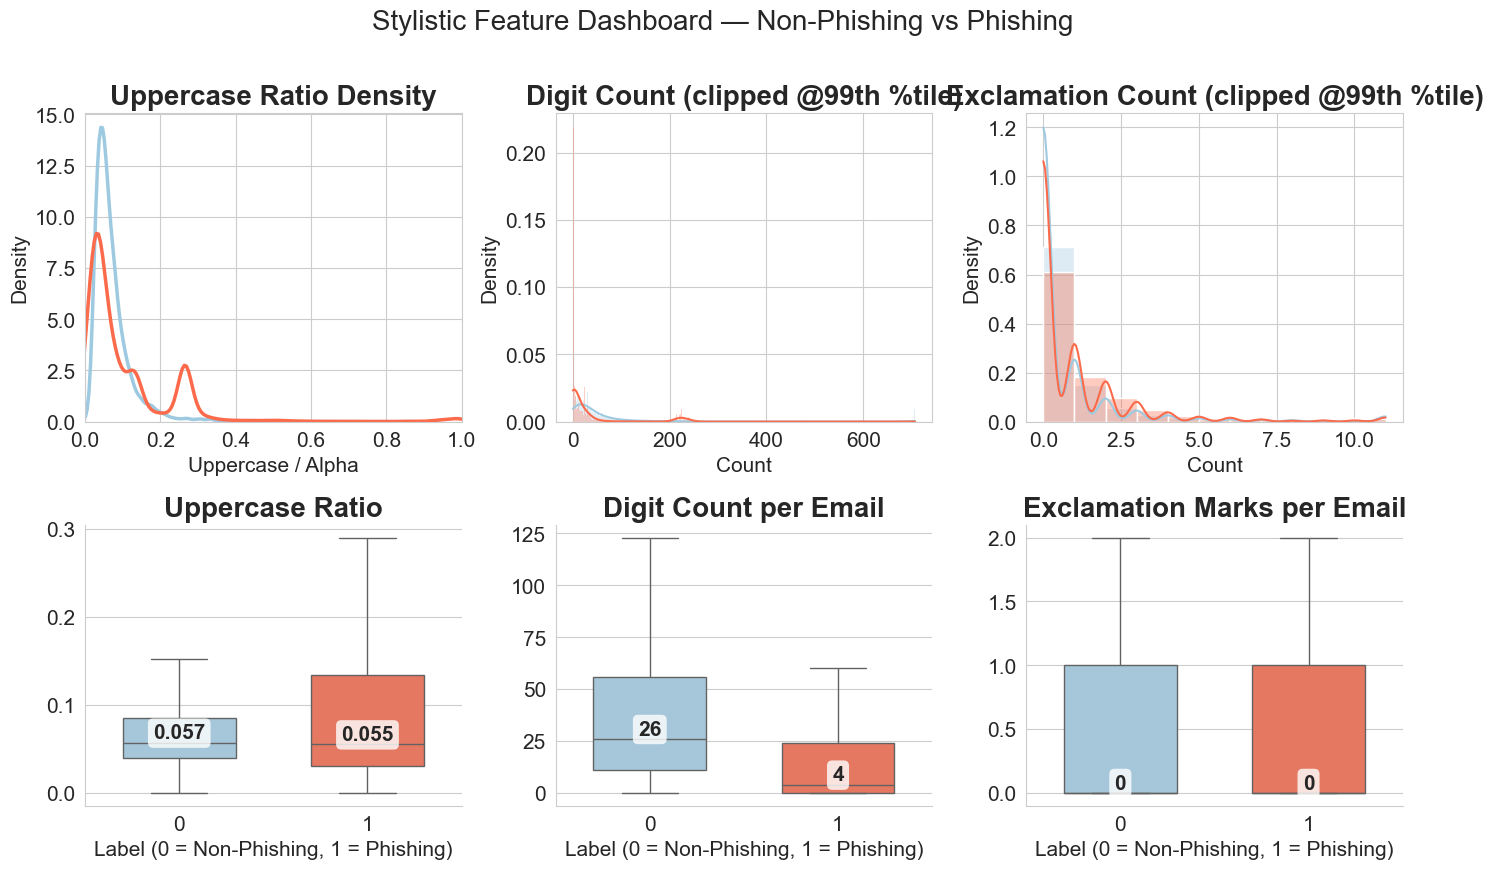

Saved figure to: text_eda_12.png


In [56]:
viz = df.copy()
viz['label_str'] = viz['label'].astype(str)
viz['exclaim_count_clip'] = viz['exclaim_count'].clip(upper=np.nanpercentile(viz['exclaim_count'], 99))
viz['digit_count_clip']   = viz['digit_count'].clip(upper=np.nanpercentile(viz['digit_count'], 99))
viz['upper_ratio_clip']   = viz['upper_ratio'].clip(0, 1)

order   = ['0','1']
palette = {'0': "#9ecae1", '1': "#fb6a4a"}

fig = plt.figure(figsize=(17, 9))
gs  = fig.add_gridspec(2, 3, height_ratios=[1.1, 1], hspace=0.35, wspace=0.25)

# ---------- Top row ----------
ax_upper, ax_digit, ax_exclaim = fig.add_subplot(gs[0,0]), fig.add_subplot(gs[0,1]), fig.add_subplot(gs[0,2])

# Uppercase ratio KDE
for lbl in order:
    sub = viz[viz['label_str'] == lbl]
    sns.kdeplot(sub['upper_ratio_clip'].dropna(),
                ax=ax_upper, lw=2.5,
                color=palette[lbl], label=f'label={lbl}')
ax_upper.set_title('Uppercase Ratio Density', fontsize=20, weight='bold')
ax_upper.set_xlabel('Uppercase / Alpha', fontsize=15)
ax_upper.set_ylabel('Density', fontsize=15)
ax_upper.tick_params(axis='both', labelsize=15)
ax_upper.set_xlim(0, 1)

# Digit count
bins_dg = np.histogram_bin_edges(viz['digit_count_clip'], bins='auto')
for lbl in order:
    sub = viz[viz['label_str'] == lbl]
    sns.histplot(sub['digit_count_clip'], bins=bins_dg,
                 ax=ax_digit, stat='density',
                 kde=True, alpha=0.35,
                 color=palette[lbl], label=f'label={lbl}')
ax_digit.set_title('Digit Count (clipped @99th %tile)', fontsize=20, weight='bold')
ax_digit.set_xlabel('Count', fontsize=15)
ax_digit.set_ylabel('Density', fontsize=15)
ax_digit.tick_params(axis='both', labelsize=15)

# Exclamation count
bins_ex = np.histogram_bin_edges(viz['exclaim_count_clip'], bins='auto')
for lbl in order:
    sub = viz[viz['label_str'] == lbl]
    sns.histplot(sub['exclaim_count_clip'], bins=bins_ex,
                 ax=ax_exclaim, stat='density',
                 kde=True, alpha=0.35,
                 color=palette[lbl], label=f'label={lbl}')
ax_exclaim.set_title('Exclamation Count (clipped @99th %tile)', fontsize=20, weight='bold')
ax_exclaim.set_xlabel('Count', fontsize=15)
ax_exclaim.set_ylabel('Density', fontsize=15)
ax_exclaim.tick_params(axis='both', labelsize=15)

# ---------- Bottom row ----------
bx1, bx2, bx3 = fig.add_subplot(gs[1,0]), fig.add_subplot(gs[1,1]), fig.add_subplot(gs[1,2])

def labeled_boxplot(ax, y, title, fmt_commas=False):
    sns.boxplot(data=viz, x='label_str', y=y, ax=ax, palette=palette,
                order=order, showcaps=True, showfliers=False, width=0.6)
    meds = viz.groupby('label_str')[y].median().reindex(order)

    for i, (lbl, med) in enumerate(meds.items()):
        txt = f'{med:,.0f}' if fmt_commas else (f'{med:.3f}' if 'ratio' in y else f'{med:.0f}')
        ax.text(i, med, txt,
                ha='center', va='bottom',
                fontsize=15, weight='bold',
                bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='none', alpha=0.8))

    ax.set_title(title, fontsize=20, weight='bold')
    ax.set_xlabel('Label (0 = Non-Phishing, 1 = Phishing)', fontsize=15)
    ax.set_ylabel('')
    ax.tick_params(axis='both', labelsize=15)
    sns.despine(ax=ax)

labeled_boxplot(bx1, 'upper_ratio_clip',   'Uppercase Ratio')
labeled_boxplot(bx2, 'digit_count_clip',   'Digit Count per Email', fmt_commas=True)
labeled_boxplot(bx3, 'exclaim_count_clip', 'Exclamation Marks per Email')

bx2.yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x):,}'))

# ---------- Suptitle ----------
n0, n1 = (viz['label_str']=='0').sum(), (viz['label_str']=='1').sum()
fig.suptitle(
    f'Stylistic Feature Dashboard — Non-Phishing vs Phishing',
    y=0.995, fontsize=20
)

plt.tight_layout(rect=[0, 0.02, 1, 0.93])

save_path = "text_eda_12.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"Saved figure to: {save_path}")


In [20]:
from scipy.stats import mannwhitneyu

features = ['exclaim_count', 'digit_count', 'special_count', 'upper_ratio']
for col in features:
    stat, p = mannwhitneyu(df.loc[df.label==0, col],
                           df.loc[df.label==1, col],
                           alternative='two-sided')
    print(f"{col}: U={stat:.2f}, p-value={p:.4g}")

exclaim_count: U=266624066.00, p-value=9.619e-129
digit_count: U=419312599.00, p-value=0
special_count: U=478388142.50, p-value=0
upper_ratio: U=nan, p-value=nan


- **Strong evidence** that legitimate and phishing emails differ in **exclamation, digit, and special-character usage** (p < 0.001).  
- **No significant difference** in uppercase ratio despite visual variance; capitalization alone is not a reliable discriminator.  
- Overall, phishing messages are **simpler and less formatted**, while ham emails are **longer and more structured** with richer punctuation and metadata.

**Conclusion:**  
Phishing and ham emails exhibit statistically distinct stylistic patterns—particularly in punctuation and numeric content—supporting the hypothesis that phishing relies on brevity and emotional emphasis, whereas legitimate messages are content-dense and formally formatted.

In [21]:
df[['label','exclaim_count','upper_ratio','digit_count']].corr()['label']

label            1.000000
exclaim_count   -0.020172
upper_ratio      0.164896
digit_count     -0.003322
Name: label, dtype: float64

<Axes: >

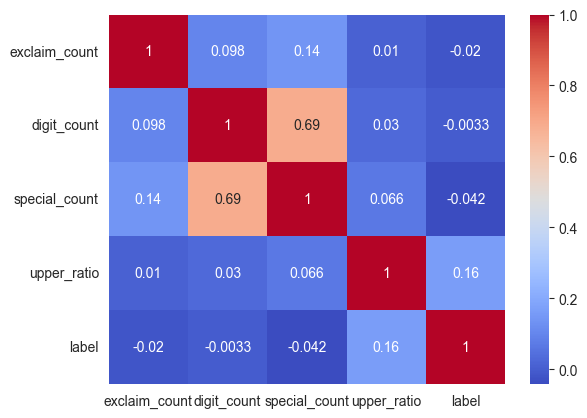

In [22]:
sns.heatmap(df[['exclaim_count','digit_count','special_count','upper_ratio','label']].corr(),
            annot=True, cmap='coolwarm')

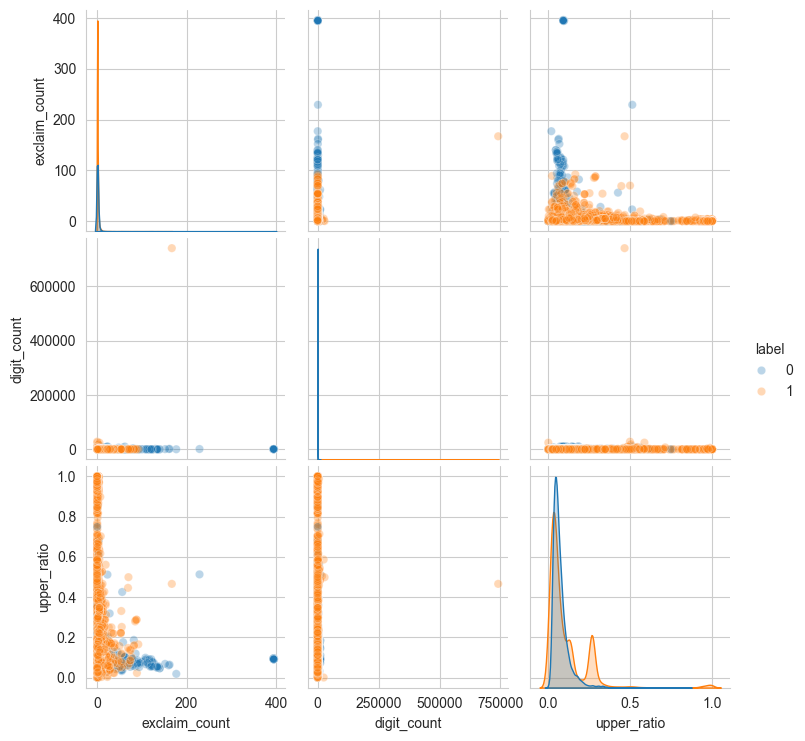

In [23]:
sns.pairplot(df, vars=['exclaim_count','digit_count','upper_ratio'], hue='label', plot_kws={'alpha':0.3})

## Sender Domain

In [24]:
df['sender_domain'] = df['sender'].fillna('').astype(str).apply(lambda x: x.split('@')[-1] if '@' in x else 'unknown')

print("="*50)
print("TOP 10 SENDER DOMAINS - HAM")
print("="*50)
print(df[df['label']==0]['sender_domain'].value_counts().head(10))
print("\n")

print("="*50)
print("TOP 10 SENDER DOMAINS - SPAM")
print("="*50)
print(df[df['label']==1]['sender_domain'].value_counts().head(10))
# 1) Compare to your earlier text output
print(df[df['label']==0]['sender_domain'].value_counts().head(10))
print(df[df['label']==1]['sender_domain'].value_counts().head(10))

# 2) How many 'unknown' by class?
print(df.groupby('label')['sender_domain'].apply(lambda s:(s=='unknown').sum()))

# 3) Inspect raw rows for a “weird” domain (e.g., 'merriam-webster.com')
print(df[df['sender'].str.contains('merriam', case=False, na=False)][['sender','label']].head(10))


TOP 10 SENDER DOMAINS - HAM
sender_domain
gmail.com>                 2610
spamassassin.taint.org>     602
python.org>                 523
issues.apache.org           462
v.loewis.de>                289
perl.org>                   209
telefonica.net>             208
hotmail.com>                206
lists.techtarget.com>       201
hotpop.com>                 183
Name: count, dtype: int64


TOP 10 SENDER DOMAINS - SPAM
sender_domain
unknown          986
hotmail.com>     427
yahoo.com>       394
google.com>      209
virgilio.it>     152
yahoo.co.uk>     116
hotmail.fr>      107
netscape.net>     91
msn.com>          91
yahoo.com         85
Name: count, dtype: int64
sender_domain
gmail.com>                 2610
spamassassin.taint.org>     602
python.org>                 523
issues.apache.org           462
v.loewis.de>                289
perl.org>                   209
telefonica.net>             208
hotmail.com>                206
lists.techtarget.com>       201
hotpop.com>                 1

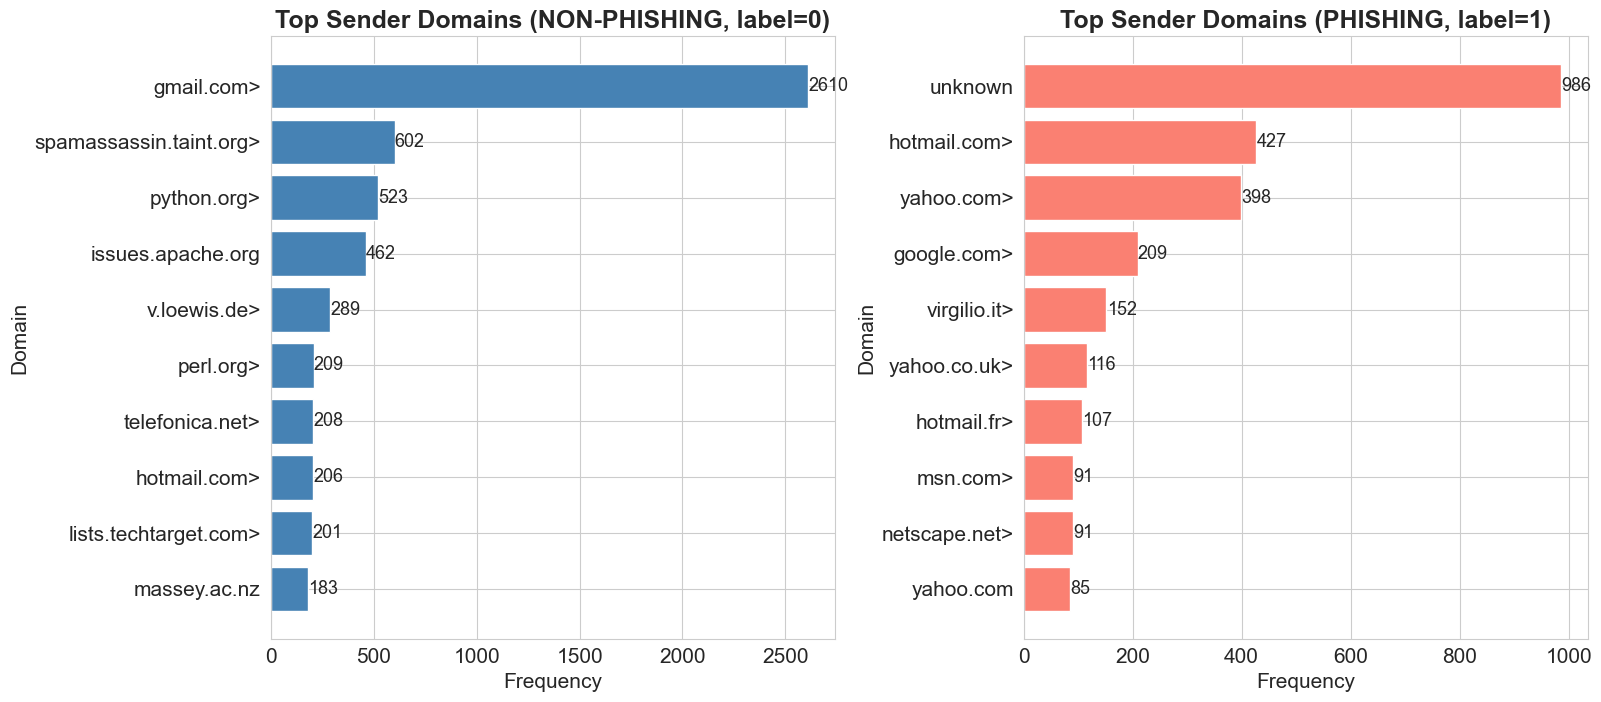

Saved figure to: text_eda_11.png


In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure domain extraction exists
df['sender_domain'] = (
    df['sender']
    .fillna('')
    .astype(str)
    .apply(lambda x: x.split('@')[-1].lower() if '@' in x else 'unknown')
)

# Compute top domains
top_ham = df[df['label']==0]['sender_domain'].value_counts().head(10)
top_spam = df[df['label']==1]['sender_domain'].value_counts().head(10)

# Create side-by-side figure (NO shared y-axis)
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=False)

# --- Left: HAM ---
counts_ham = top_ham.sort_values()
axes[0].barh(counts_ham.index, counts_ham.values, color="steelblue")
axes[0].set_title("Top Sender Domains (NON-PHISHING, label=0)",
                  fontsize=18, fontweight='bold')
axes[0].set_xlabel("Frequency", fontsize=15)
axes[0].set_ylabel("Domain", fontsize=15)
axes[0].tick_params(axis='both', labelsize=15)

for i, v in enumerate(counts_ham.values):
    axes[0].text(v + 0.5, i, str(v), va='center', fontsize=13)

# --- Right: SPAM ---
counts_spam = top_spam.sort_values()
axes[1].barh(counts_spam.index, counts_spam.values, color="salmon")
axes[1].set_title("Top Sender Domains (PHISHING, label=1)",
                  fontsize=18, fontweight='bold')
axes[1].set_xlabel("Frequency", fontsize=15)
axes[1].set_ylabel("Domain", fontsize=15)
axes[1].tick_params(axis='both', labelsize=15)

for i, v in enumerate(counts_spam.values):
    axes[1].text(v + 0.5, i, str(v), va='center', fontsize=13)

plt.tight_layout()

# Save figure
save_path = "text_eda_11.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved figure to: {save_path}")


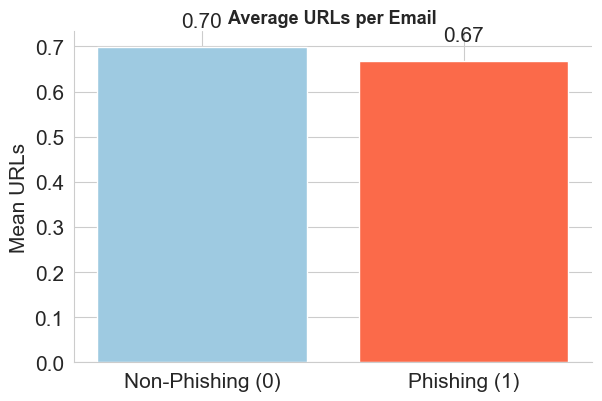

Saved WordCloud figure to: text_eda_5.png


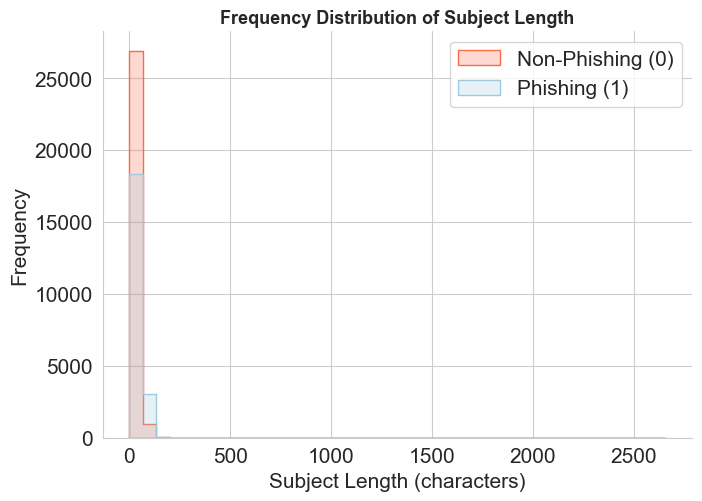

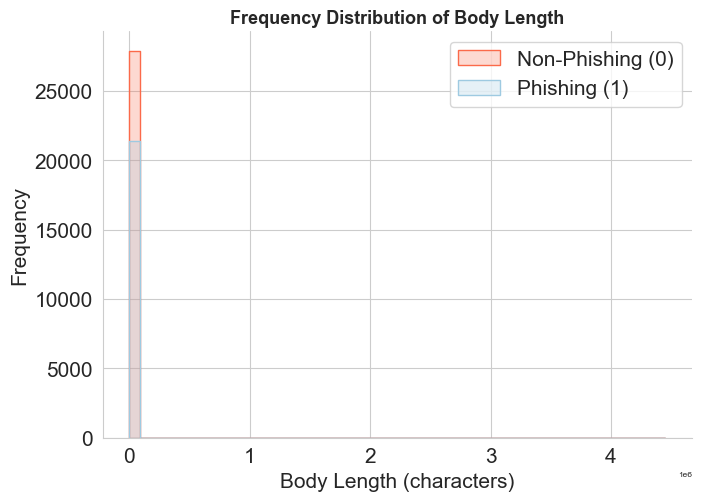

In [40]:
sns.set_style("whitegrid")
palette = ['#9ecae1', '#fb6a4a'] 
order = [0, 1]

# ---------- 2. Average URLs per Email ----------
avg_urls = df.groupby('label')['urls'].mean().reindex(order)
plt.figure(figsize=(6, 4))
bars = plt.bar(['Non-Phishing (0)', 'Phishing (1)'], avg_urls.values, color=palette, edgecolor='white')
offset2 = avg_urls.max() * 0.05
for i, v in enumerate(avg_urls.values):
    plt.text(i, v + offset2, f"{v:.2f}", ha='center', va='bottom', fontsize=15)
plt.xticks(fontsize=15)
plt.title("Average URLs per Email", fontsize=13, weight='bold')
plt.ylabel("Mean URLs",fontsize=15)
plt.yticks(fontsize=15)
sns.despine()
plt.tight_layout()
save_path = "text_eda_5.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')

plt.show()

print(f"Saved WordCloud figure to: {save_path}")

# ---------- 3. Subject Length Frequency Diagram ----------
plt.figure(figsize=(7, 5))
sns.histplot(data=df, x='subject_len', hue='label', palette=palette, bins=40,
             kde=False, element='step', common_norm=False)
plt.title("Frequency Distribution of Subject Length", fontsize=13, weight='bold')
plt.xlabel("Subject Length (characters)", fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.yticks(fontsize=15)
plt.legend(labels=['Non-Phishing (0)', 'Phishing (1)'],fontsize=15)
sns.despine()
plt.tight_layout()
plt.show()

# ---------- 4. Body Length Frequency Diagram ----------
plt.figure(figsize=(7, 5))
sns.histplot(data=df, x='body_len', hue='label', palette=palette, bins=50,
             kde=False, element='step', common_norm=False)
plt.title("Frequency Distribution of Body Length", fontsize=13, weight='bold')
plt.xlabel("Body Length (characters)",fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel("Frequency",fontsize=15)
plt.yticks(fontsize=15)
plt.legend(labels=['Non-Phishing (0)', 'Phishing (1)'],fontsize=15)
sns.despine()
plt.tight_layout()
plt.show()


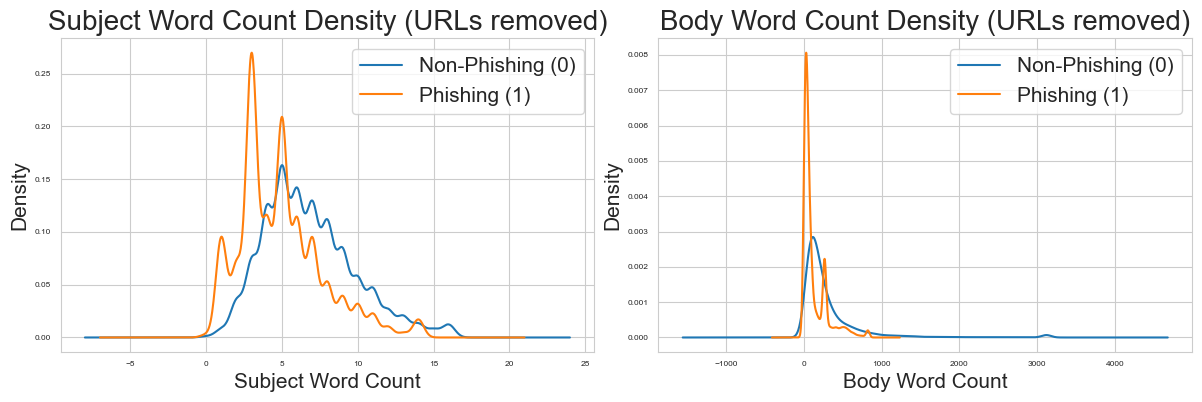

Saved WordCloud figure to: text_eda_2.png


In [31]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 6}) 
# --- Extract and drop NaNs ---
sub_ham  = df.loc[df['label'] == 0, 'subject_word_count'].dropna()
sub_spam = df.loc[df['label'] == 1, 'subject_word_count'].dropna()

body_ham  = df.loc[df['label'] == 0, 'body_word_count'].dropna()
body_spam = df.loc[df['label'] == 1, 'body_word_count'].dropna()

# --- Clip outliers to 99th percentile ---
def clip99(series):
    q99 = np.nanpercentile(series, 99)
    return series.clip(upper=q99)

sub_ham_c  = clip99(sub_ham)
sub_spam_c = clip99(sub_spam)
body_ham_c  = clip99(body_ham)
body_spam_c = clip99(body_spam)

# --- Plot ---
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Subject word count density
sub_ham_c.plot(kind='kde', ax=axes[0], label='Non-Phishing (0)')
sub_spam_c.plot(kind='kde', ax=axes[0], label='Phishing (1)')
axes[0].set_title("Subject Word Count Density (URLs removed)", fontsize=20)
axes[0].set_xlabel("Subject Word Count", fontsize=15)
axes[0].set_ylabel("Density", fontsize=15)
axes[0].legend(fontsize=15)

# Body word count density
body_ham_c.plot(kind='kde', ax=axes[1], label='Non-Phishing (0)')
body_spam_c.plot(kind='kde', ax=axes[1], label='Phishing (1)')
axes[1].set_title("Body Word Count Density (URLs removed)",fontsize=20)
axes[1].set_xlabel("Body Word Count", fontsize=15)
axes[1].set_ylabel("Density",fontsize=15)
axes[1].legend(fontsize=15)

plt.tight_layout()
save_path = "text_eda_2.png"
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved WordCloud figure to: {save_path}")
